In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import os
import meshio


In [2]:
# Inicializar Gmsh
gmsh.initialize()

# Abrir archivo .geo
file = "llave.geo"
gmsh.open(file)  # <-- Esta es la clave para cargar la geometría

# Añadir nombre del modelo (opcional si ya está en el archivo)
gmsh.model.setCurrent("llave")

# Sincronizar por si quieres modificar algo en Python
gmsh.model.geo.synchronize()

# Lanzar la interfaz gráfica para visualizar
#gmsh.fltk.run()

# Finalizar Gmsh cuando termines
gmsh.finalize()


Info    : Reading 'llave.geo'...
Info    : Done reading 'llave.geo'


In [3]:
#Establezco el tamaño de la malla
lc = 3

# Inicializar Gmsh
gmsh.initialize()

# Cargar archivo .geo
gmsh.open(file)

# Establecer parámetros de mallado
gmsh.option.setNumber("Mesh.CharacteristicLengthMin", lc)
gmsh.option.setNumber("Mesh.CharacteristicLengthMax", lc)

# Sincronizar (por si hay geometría a modificar, aunque ya fue cargada)
gmsh.model.geo.synchronize()

# Generar la malla (2 = malla 2D, 3 = malla 3D)
gmsh.model.mesh.generate(3)

# Exportar la malla a archivo .msh si lo deseas
output_file = 'malla.msh'
gmsh.write(output_file)

# Visualizar
#gmsh.fltk.run()

gmsh.finalize()

Info    : Reading 'llave.geo'...
Info    : Done reading 'llave.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 101 (Circle)
Info    : [ 10%] Meshing curve 102 (Line)
Info    : [ 10%] Meshing curve 103 (Circle)
Info    : [ 20%] Meshing curve 104 (Line)
Info    : [ 20%] Meshing curve 201 (Circle)
Info    : [ 30%] Meshing curve 202 (Circle)
Info    : [ 30%] Meshing curve 203 (Line)
Info    : [ 30%] Meshing curve 204 (Line)
Info    : [ 40%] Meshing curve 205 (Circle)
Info    : [ 40%] Meshing curve 206 (Circle)
Info    : [ 50%] Meshing curve 207 (Circle)
Info    : [ 50%] Meshing curve 208 (Circle)
Info    : [ 60%] Meshing curve 301 (Line)
Info    : [ 60%] Meshing curve 302 (Line)
Info    : [ 60%] Meshing curve 303 (Circle)
Info    : [ 70%] Meshing curve 304 (Circle)
Info    : [ 70%] Meshing curve 305 (Circle)
Info    : [ 80%] Meshing curve 306 (Line)
Info    : [ 80%] Meshing curve 307 (Line)
Info    : [ 80%] Meshing curve 401 (Line)
Info    : [ 90%] Meshing curve 402 (Line)
Info

In [4]:
import meshio

# Cargar el archivo de malla .msh (versión 4.1 de Gmsh)
mesh = meshio.read(output_file)

for i, (cell_block, phys_ids) in enumerate(zip(mesh.cells, mesh.cell_data["gmsh:physical"])):
    print(f"Block {i} - Tipo: {cell_block.type}, Cantidad: {len(cell_block.data)}, Physical tags: {set(phys_ids)}")



Block 0 - Tipo: line, Cantidad: 6, Physical tags: {5}
Block 1 - Tipo: line, Cantidad: 6, Physical tags: {6}
Block 2 - Tipo: line, Cantidad: 8, Physical tags: {7}
Block 3 - Tipo: triangle, Cantidad: 128, Physical tags: {1}
Block 4 - Tipo: triangle, Cantidad: 232, Physical tags: {2}
Block 5 - Tipo: triangle, Cantidad: 182, Physical tags: {3}
Block 6 - Tipo: triangle, Cantidad: 157, Physical tags: {4}


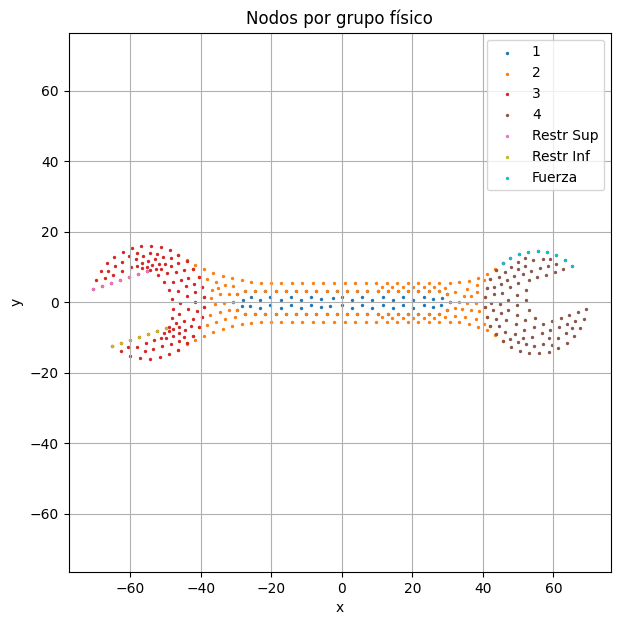

In [5]:
import meshio
from nodes import Node

# Leer archivo .msh
mesh = meshio.read(output_file)

# Asociación de tag físico con nombre
tag_to_name = {v[0]: k for k, v in mesh.field_data.items()}

# Diccionario {nombre_grupo: [Node, Node, ...]}
grupos = {}

# Procesar elementos tipo triangle
for cell_block, phys_tags in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
    if cell_block.type != "triangle":
        continue
    for tri, tag in zip(cell_block.data, phys_tags):
        nombre = tag_to_name.get(tag, f"{tag}")
        if nombre not in grupos:
            grupos[nombre] = []
        for node_id in tri:
            x, y = mesh.points[node_id][:2]
            grupos[nombre].append(Node(node_id, x, y))

# Procesar elementos tipo line (para grupos como "Fuerza")
for cell_block, phys_tags in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
    if cell_block.type != "line":
        continue
    for line, tag in zip(cell_block.data, phys_tags):
        nombre = tag_to_name.get(tag, f"{tag}")
        if nombre not in grupos:
            grupos[nombre] = []
        for node_id in line:
            x, y = mesh.points[node_id][:2]
            restrain = [0, 0]
            if nombre in ["Restr Sup", "Restr Inf"]:
                restrain = [1, 1]
            grupos[nombre].append(Node(node_id, x, y, restrain=restrain))


# Eliminar nodos duplicados por grupo
for nombre in grupos:
    nodos_unicos = {}
    for n in grupos[nombre]:
        nodos_unicos[n.id] = n
    grupos[nombre] = list(nodos_unicos.values())

# Graficar por grupo
Node.plot_nodes_por_grupo(grupos, show_ids=False)


In [6]:
from section import Section

#Ahora creo las 4 secciones posibles
thicknes = {"1": 2.0, "2": 4.0, "3": 5.0, "4": 5.0}
sections = {}

#Defino las propiedades del material

E = 210000
nu = 0.3
rho = 7850

for group in thicknes:
    sections[group] = Section(thicknes[group], E, nu)


In [7]:
nodes_dict = {}
nodes = []
for group in grupos:
    for node in grupos[group]:
        nodes_dict[node.id] = node
        nodes.append(node)


In [8]:
from cst import CST

triangles = mesh.cells_dict['triangle']  # nodos por cada triángulo
tags = mesh.cell_data_dict["gmsh:physical"]["triangle"]
elements = []

for i in range(len(tags)):
    section = sections[str(tags[i])]

    node_ids = triangles[i]
    nodo_a = nodes_dict[node_ids[0]]
    nodo_b = nodes_dict[node_ids[1]]
    nodo_c = nodes_dict[node_ids[2]]

    for nodo in [nodo_a, nodo_b, nodo_c]:
        if np.all(nodo.restrain == [1, 1]):
            print(f"Nodo {nodo.id} con restricción total está en elemento {i+1}")

    elem = CST(i+1, [nodo_a, nodo_b, nodo_c], section)
    elements.append(elem)




Nodo 169 con restricción total está en elemento 374
Nodo 17 con restricción total está en elemento 374
Nodo 16 con restricción total está en elemento 376
Nodo 164 con restricción total está en elemento 376
Nodo 173 con restricción total está en elemento 396
Nodo 15 con restricción total está en elemento 396
Nodo 14 con restricción total está en elemento 401
Nodo 168 con restricción total está en elemento 401
Nodo 166 con restricción total está en elemento 409
Nodo 164 con restricción total está en elemento 415
Nodo 165 con restricción total está en elemento 415
Nodo 170 con restricción total está en elemento 420
Nodo 169 con restricción total está en elemento 420
Nodo 172 con restricción total está en elemento 438
Nodo 171 con restricción total está en elemento 438
Nodo 165 con restricción total está en elemento 440
Nodo 166 con restricción total está en elemento 440
Nodo 167 con restricción total está en elemento 443
Nodo 170 con restricción total está en elemento 445
Nodo 167 con res

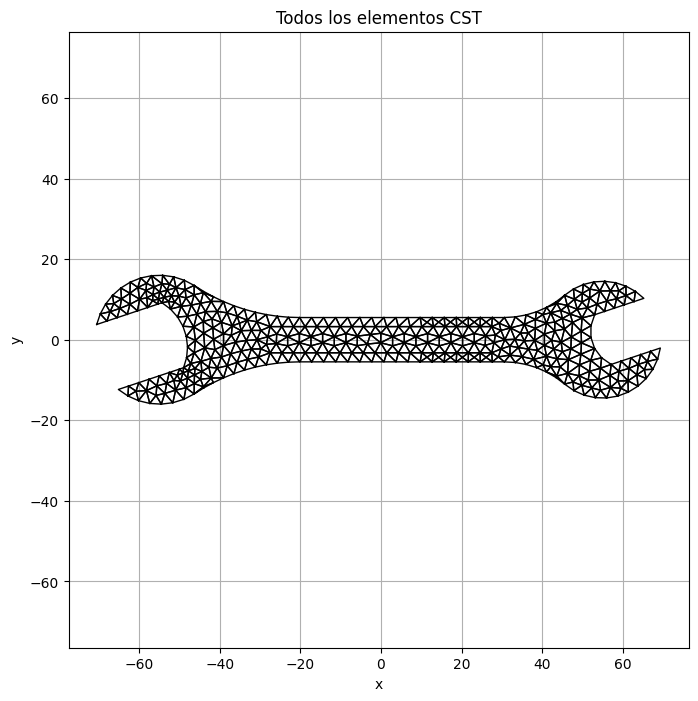

In [9]:
import matplotlib.pyplot as plt

def plot_all_elements(elements, show_ids=True):
    """
    Dibuja todos los elementos CST en una sola figura.

    Parámetros:
    - elements: lista de instancias de CST
    - show_ids: si True, muestra los ID de los nodos y elementos
    """
    plt.figure(figsize=(8, 8))
    
    for elem in elements:
        coords = elem.get_xy_matrix()
        coords = np.vstack([coords, coords[0]])  # cerrar triángulo

        # Dibujar contorno del triángulo
        plt.plot(coords[:, 0], coords[:, 1], 'k-', linewidth=1)

        if show_ids:
            # Mostrar ID del elemento en su centroide
            centroid = coords[:-1].mean(axis=0)
            plt.text(centroid[0], centroid[1], str(elem.element_tag), color='red', fontsize=8)


    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis('equal')
    plt.grid(True)
    plt.title("Todos los elementos CST")
    plt.show()


plot_all_elements(elements, show_ids=False)

In [10]:
for key, sec in sections.items():
    if sec.E == 0 or sec.thickness == 0:
        print(f"❌ Sección {key} tiene propiedades inválidas: E = {sec.E}, t = {sec.thickness}")
    else:
        print(f"✅ Sección {key} OK: E = {sec.E}, t = {sec.thickness}")


✅ Sección 1 OK: E = 210000, t = 2.0
✅ Sección 2 OK: E = 210000, t = 4.0
✅ Sección 3 OK: E = 210000, t = 5.0
✅ Sección 4 OK: E = 210000, t = 5.0


In [11]:
from solve import Solve

estructure = Solve(nodes, elements)

In [12]:
# Aplicar fuerza vertical arbitraria en el grupo "Fuerza"
if "Fuerza" in grupos:
    nodos_fuerza = grupos["Fuerza"]
    Py_total = -100.0  # N negativos = hacia abajo (puedes cambiarlo)
    f_por_nodo = Py_total / len(nodos_fuerza)

    for nodo in nodos_fuerza:
        dof_y = nodo.id * 2 + 1
        estructure.apply_force(dof_index=dof_y, value=-50.0)  # Por ejemplo, 50 N hacia abajo

In [13]:
desplazamientos = estructure.solve()

❌ Fila(s) completamente nulas en K_global: [ 840  841  842  843  844  845  846  847  848  849  850  851  852  853
  854  855  856  857  858  859  860  861  862  863  864  865  866  867
  868  869  870  871  872  873  874  875  876  877  878  879  880  881
  882  883  884  885  886  887  888  889  890  891  892  893  894  895
  896  897  898  899  900  901  902  903  904  905  906  907  908  909
  910  911  912  913  914  915  916  917  918  919  920  921  922  923
  924  925  926  927  928  929  930  931  932  933  934  935  936  937
  938  939  940  941  942  943  944  945  946  947  948  949  950  951
  952  953  954  955  956  957  958  959  960  961  962  963  964  965
  966  967  968  969  970  971  972  973  974  975  976  977  978  979
  980  981  982  983  984  985  986  987  988  989  990  991  992  993
  994  995  996  997  998  999 1000 1001 1002 1003 1004 1005 1006 1007
 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020 1021]
DOF 840 (ux) corresponde al nodo 

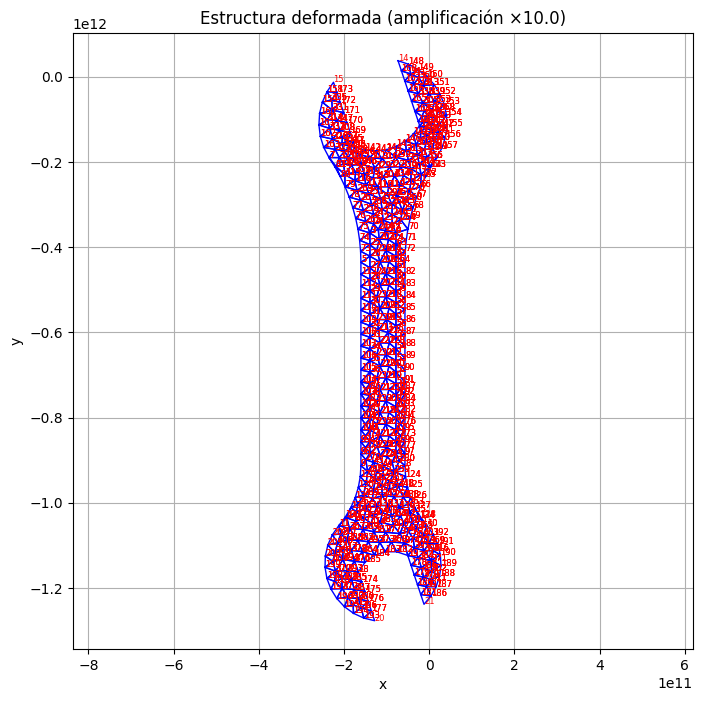

In [15]:


def plot_deformed_structure(elements, scale=1.0, show_ids=False):
    """
    Dibuja estructura original y deformada en el plano XY.

    Parámetros:
    - elements: lista de elementos (tipo CST)
    - scale: factor de amplificación de la deformación
    - show_ids: si True, muestra los IDs de los nodos
    """
    plt.figure(figsize=(8, 8))

    for elem in elements:
        coords = elem.get_xy_matrix()  # shape (3, 2) → [[x1, y1], [x2, y2], [x3, y3]]
        u = np.zeros_like(coords)

        # Obtener desplazamientos globales de cada nodo
        for i, nodo in enumerate(elem.node_list):
            ux = nodo.structure.u_global[nodo.dofs[0], 0]
            uy = nodo.structure.u_global[nodo.dofs[1], 0]
            u[i] = [ux, uy]

        # Dibujar triángulo original
        coords_closed = np.vstack([coords, coords[0]])
        plt.plot(coords_closed[:, 0], coords_closed[:, 1], 'gray', linewidth=0.5)

        # Dibujar triángulo deformado
        def_coords = coords + scale * u
        def_coords_closed = np.vstack([def_coords, def_coords[0]])
        plt.plot(def_coords_closed[:, 0], def_coords_closed[:, 1], 'b', linewidth=1.0)

        if show_ids:
            for i, nodo in enumerate(elem.node_list):
                x, y = def_coords[i]
                plt.text(x, y, str(nodo.id), fontsize=6, color='red')

    plt.title(f"Estructura deformada (amplificación ×{scale})")
    plt.axis('equal')
    plt.grid(True)
    plt.xlabel("x")
    plt.ylabel("y")  # Y como vertical
    plt.show()


# Importante: guardar los desplazamientos en cada nodo
for node in estructure.nodes:
    node.structure = estructure  # para acceder a u_global desde cada nodo

# Luego graficar
plot_deformed_structure(estructure.elements, scale=10.0, show_ids=True)